### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import numpy as np
from joblib import Parallel, delayed
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import math
from collections import Counter
from skimage.transform import resize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
import seaborn as sns

### Features

In [2]:

def _rms(data):
	"""
	Root Mean Square.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: RMS feature.
	"""
	return math.sqrt(np.power(data, 2).sum() / len(data))

def _zc(data):
	"""
	Zero Crossing.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: ZC feature.
	"""
	return len(np.where(np.diff(np.sign(data)))[0])

def _var(data):
	"""
	Variance.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: Variance feature.
	"""
	return np.var(data)

def _mav(data):
	"""
	Mean Absolute Value.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: MAV feature.
	"""
	return np.mean(np.abs(data))

def _sscl(data):
	"""
	Slope Sign Change List.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: SSC feature.
	"""
	diff_signal = np.diff(data)
	sign_changes = np.diff(np.sign(diff_signal))
 
	return np.sum(sign_changes != 0)

def _wl(data):
	"""
	Waveform Length.

	Arguments:
			@var data: list of graph data.

	Returns:
			@return: WL feature.
	"""
	return np.sum(np.abs(np.diff(data)))
def _hrm(data):

    mean = np.mean(data)
    return sum([i for i in data if i>abs(mean)])

### Carregando os dados

In [3]:
file = open('./data/MyoArmband_data.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

n = len(MyoArm_data.values())

df = pd.DataFrame()

S1_emg = MyoArm_data['S1']['emg']
S1_label = MyoArm_data['S1']['label']

emg_data = np.array(S1_emg)
labels= np.array(S1_label)

for i in range(n):
  key = f"S{i+1}"
  data = MyoArm_data[key]
  emg_data = np.concatenate((emg_data, data['emg']), axis=0)
  labels = np.concatenate((labels, data['label']), axis=0)


df = pd.DataFrame({
  'emg': list(emg_data),
  'label': list(labels),
})
df = df.explode('label')

gestures_list = [i for i in set(df['label'])]
resized_df = df[df['label'].isin(gestures_list)]

emg_df = pd.DataFrame(resized_df['emg'].tolist(), index=resized_df.index)
emg_df.columns = [f'emg_{i+1}' for i in range(emg_df.shape[1])]
emg_df = pd.concat([emg_df, resized_df['label']], axis=1)
emg_df['label'] = emg_df['label'].astype(int)

### Calculando as features

In [ ]:

def mk_features(emg_df):
    ftrs = ['rms', 'zc', 'var', 'mav', 'sscl', 'wl', 'hrm']
    n_channels = 16
    
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in ftrs]
    columns.append('label')
    features_df = pd.DataFrame(columns=columns)
    
    #@dask.delayed
    def process(window, n_channels=16):
      row = {}
      label = np.array(window['label'])
      mostCommonLabel = Counter(label).most_common(1)[0][0]
    
      for i in range(n_channels):
        channel_data = window[f'emg_{i+1}']
    
        rms = _rms(channel_data)
        zc = _zc(channel_data)
        var = _var(channel_data)
        mav = _mav(channel_data)
        sscl = _sscl(channel_data)
        wl = _wl(channel_data)
        hrm = _hrm(channel_data)
    
        row[f'rms_{i+1}'] = rms
        row[f'zc_{i+1}'] = zc
        row[f'var_{i+1}'] = var
        row[f'mav_{i+1}'] = mav
        row[f'sscl_{i+1}'] = sscl
        row[f'wl_{i+1}'] = wl
        row[f'hrm_{i+1}'] = hrm
    
      row['label'] = mostCommonLabel
      return row
    
    window_size = 200
    step = 25
    windows = emg_df.rolling(window=window_size, step=step)
    
  
    results = Parallel(n_jobs=-1)(delayed(process)(window, n_channels=n_channels) for window in windows if len(window) == window_size)
  
    
    return pd.DataFrame(results, columns=columns)

features_df = mk_features(emg_df)

### Train and Test cases

In [5]:
X = features_df.drop('label', axis=1)
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
features_df.head()

,rms_1,zc_1,var_1,mav_1,sscl_1,wl_1,hrm_1,rms_2,zc_2,var_2,...,wl_15,hrm_15,rms_16,zc_16,var_16,mav_16,sscl_16,wl_16,hrm_16,label
0,6.786752,110,45.231899,4.280,142,1211.0,337.0,2.249444,122,4.138400,...,290.0,21.0,1.882817,110,2.452975,1.465,150,346.0,17.0,1
1,6.904346,105,46.930401,4.420,143,1229.0,356.0,2.305428,120,4.402975,...,333.0,46.0,1.881489,112,2.599100,1.440,149,351.0,47.0,1
2,7.430007,102,54.762775,4.955,145,1373.0,429.0,4.481629,121,19.074976,...,353.0,53.0,1.945508,107,2.872975,1.495,150,363.0,54.0,1
3,8.133880,100,65.763100,5.580,144,1559.0,495.0,8.099383,123,64.790001,...,476.0,59.0,1.960867,112,2.970775,1.495,143,369.0,56.0,1
4,7.400676,103,54.237099,5.470,152,1580.0,474.0,9.904292,130,96.981972,...,544.0,76.0,2.065188,108,3.254975,1.575,145,391.0,38.0,1


### Importância de features da rede neural

/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2596/2596 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Accuracy: 0.8964014399056115
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     33404
           1       0.95      0.85      0.90       971
           2       0.90      0.91      0.90       914
           3       0.96      0.91      0.93       970
           4       0.89      0.90      0.90       936
           5       0.95      0.91      0.93       977
           6       0.92      0.89      0.90       961
           7       0.91      0.90      0.90       975
           8       0.92      0.91      0.91       966
           9       0.87      0.89      0.88       939
          10       0.93      0.82      0.87      1147
          11       0.91      0.91      0.91       952
          12       0.93      0.88      0.90       996
          13       0.88      0.91      0.90       931
          14       0.92      0.90      0.91       953
          15       0.96      0.85      0.90       920
         

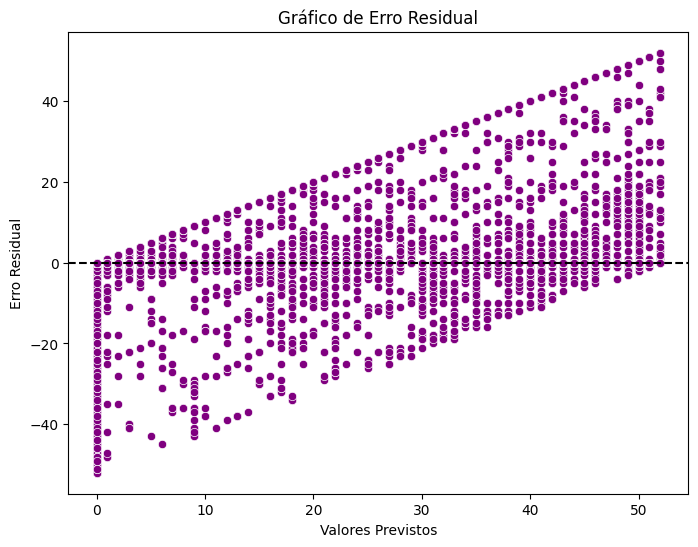

/tmp/ipykernel_133557/3885989809.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color="red")  # Linha de referência 45 graus


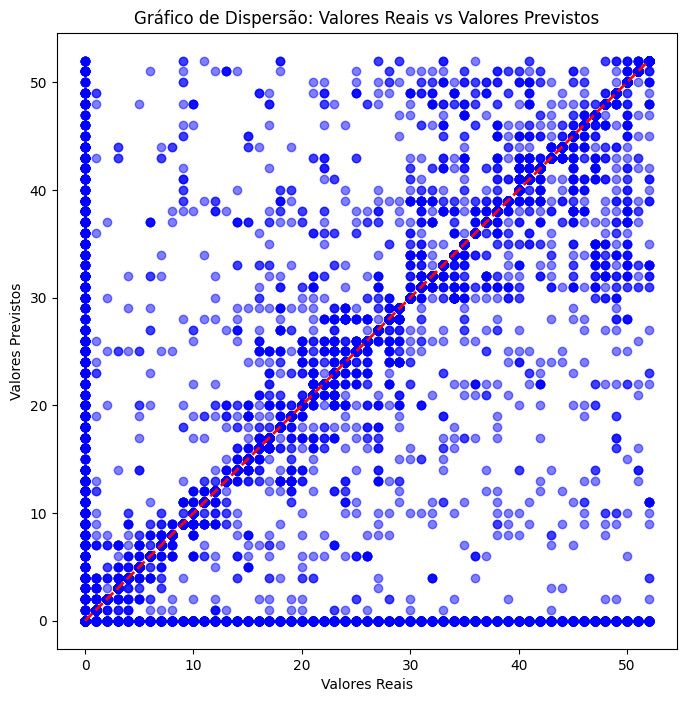

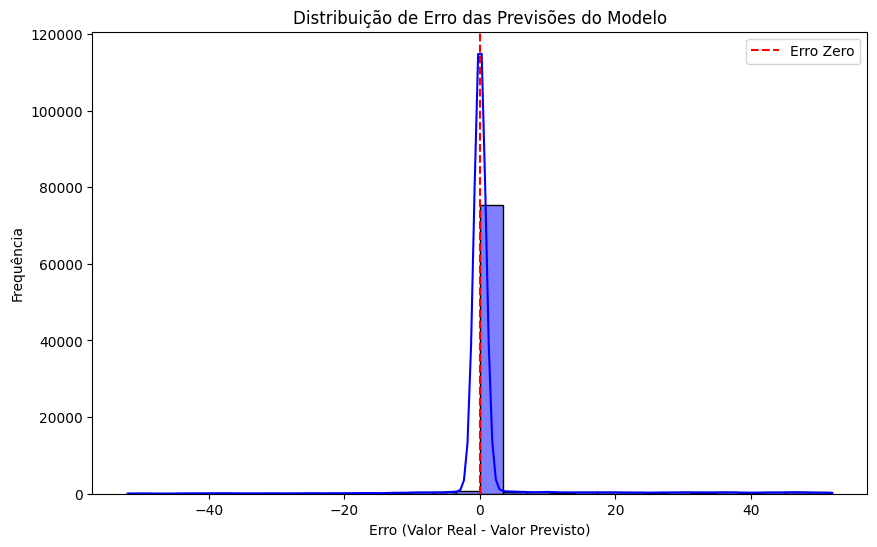

In [31]:

y_train_parsed = keras.utils.to_categorical(y_train)
y_test_parsed = keras.utils.to_categorical(y_test)

model = keras.models.Sequential()
model.add(keras.layers.Dense(2056, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(1028, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
history = model.fit(
  X_train,
  y_train_parsed,
  epochs=250,
  batch_size=5500,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

plot_residuals(y_test_classes, y_pred_classes)
plot_real_vs_pred(y_test_classes, y_pred_classes)
plot_error_distribution(y_test_classes, y_pred_classes)

/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741186196.814528   79808 service.cc:146] XLA service 0x7ba45000ca10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741186196.814548   79808 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-03-05 11:49:56.842414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-05 11:49:56.955448: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-03-05 11:49:57.507971: I exter

2591/2596 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step

2025-03-05 11:50:43.245386: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 224 bytes spill stores, 224 bytes spill loads



2596/2596 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.8637266587206992
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     33404
           1       0.86      0.86      0.86       971
           2       0.90      0.84      0.87       914
           3       0.92      0.90      0.91       970
           4       0.88      0.83      0.85       936
           5       0.93      0.89      0.91       977
           6       0.87      0.83      0.85       961
           7       0.85      0.89      0.87       975
           8       0.84      0.87      0.86       966
           9       0.86      0.83      0.84       939
          10       0.87      0.80      0.83      1147
          11       0.89      0.86      0.87       952
          12       0.87      0.84      0.85       996
          13       0.91      0.85      0.88       931
          14       0.89      0.84      0.87       953
          15       0.91      0.84      0.88       920
         

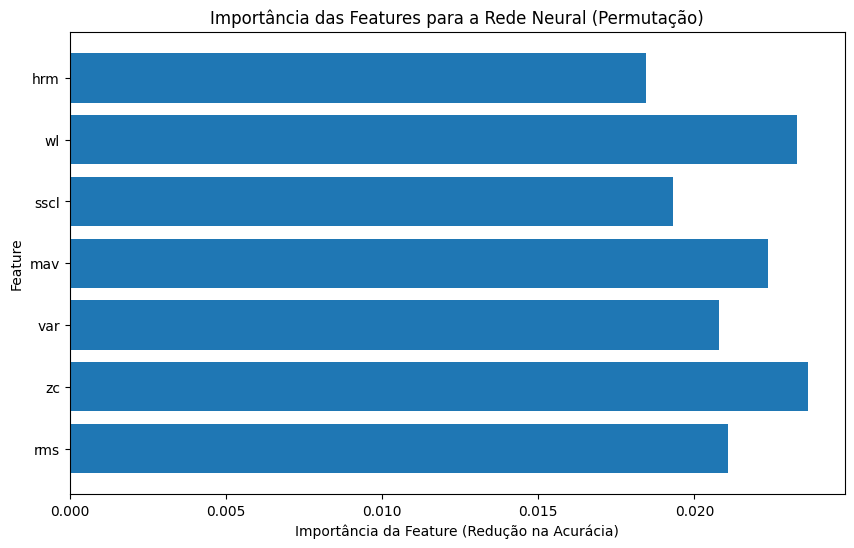

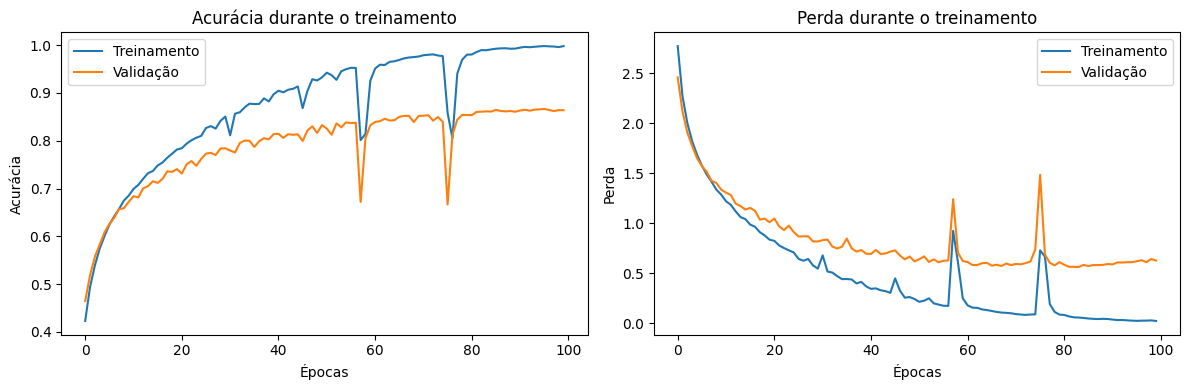

In [ ]:
y_train_parsed = keras.utils.to_categorical(y_train)
y_test_parsed = keras.utils.to_categorical(y_test)

model = keras.models.Sequential()
model.add(keras.layers.Dense(1028, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))
# Compilar o modelo
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
history = model.fit(
  X_train,
  y_train_parsed,
  epochs=100,
  batch_size=5500,
  validation_data=(X_test, y_test_parsed),
  verbose=0
)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_parsed, axis=1)


print(f'Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
print(classification_report(y_test_classes, y_pred_classes))

baseline_accuracy = accuracy_score(y_test_classes, y_pred_classes)

def permutation_importance(model, X_test, y_test_classes, baseline_accuracy):
    importances = []

    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])  # Permutar a coluna i
        # Fazer predições com a feature permutada
        y_permuted_pred = model.predict(X_test_permuted)
        y_permuted_classes = np.argmax(y_permuted_pred, axis=1)

        # Calcular a acurácia com a feature permutada
        permuted_accuracy = accuracy_score(y_test_classes, y_permuted_classes)
        importance = baseline_accuracy - permuted_accuracy
        importances.append(importance)
    return importances

# Calcular as importâncias das features
importances = permutation_importance(model, X_test, y_test_classes, baseline_accuracy)

features_mean = [0 for _ in range(int(len(importances)/16))]

for fm in range(len(features_mean)):
    for i in range(fm, len(importances), 16):
        features_mean[fm] += importances[i]
    features_mean[fm] = features_mean[fm]/16

importances = features_mean


feature_names = []

for i in range(0,len(features_mean)):
    name = X.keys()[i].split("_")[0]
    feature_names.append(name)


# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Importância da Feature (Redução na Acurácia)")
plt.ylabel("Feature")
plt.title("Importância das Features para a Rede Neural (Permutação)")
plt.savefig("./plots/features_importance_NN.png")
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.savefig("./plots/training_ef.png")
plt.show()

### KNN

In [9]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8541834596163147
              precision    recall  f1-score   support

           1       0.80      0.92      0.86       925
           2       0.83      0.93      0.87       931
           3       0.82      0.93      0.87       951
           4       0.87      0.88      0.88       954
           5       0.86      0.93      0.90      1003
           6       0.87      0.84      0.86       957
           7       0.83      0.87      0.85       999
           8       0.87      0.88      0.87       980
           9       0.81      0.90      0.85       952
          10       0.79      0.92      0.85      1185
          11       0.87      0.84      0.86       961
          12       0.83      0.90      0.86       945
          13       0.85      0.92      0.88       931
          14       0.83      0.90      0.86       940
          15       0.88      0.89      0.89       953
          16       0.84      0.86      0.85       900
          17       0.87      0.86      0.87       96

### Random Forest com cálculo de importância de features

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

feature_importances = rf.feature_importances_
feature_names = X.columns

features_mean = [0 for _ in range(int(len(feature_names)/16))]

for fm in range(len(features_mean)):
    for i in range(fm, len(feature_importances), 16):
        features_mean[fm] += feature_importances[i]
    features_mean[fm] = features_mean[fm]/16

importances = features_mean


ft_names = []

for i in range(0,len(features_mean)):
    name = feature_names[i].split("_")[0]
    ft_names.append(name)

feature_names = ft_names

# Ordenar e plotar
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feature_importances.plot(kind='bar')
plt.title('Importância das Características')
plt.show()

### SVM

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6031557310978559
              precision    recall  f1-score   support

           1       0.56      0.67      0.61       925
           2       0.59      0.72      0.65       931
           3       0.65      0.76      0.70       951
           4       0.62      0.64      0.63       954
           5       0.79      0.73      0.76      1003
           6       0.72      0.63      0.67       957
           7       0.60      0.72      0.65       999
           8       0.69      0.64      0.67       980
           9       0.60      0.57      0.59       952
          10       0.33      0.75      0.46      1185
          11       0.49      0.66      0.56       961
          12       0.55      0.62      0.58       945
          13       0.63      0.73      0.68       931
          14       0.64      0.66      0.65       940
          15       0.88      0.66      0.76       953
          16       0.62      0.60      0.61       900
          17       0.65      0.59      0.62       96

: 

## Rede neural com cruzamento e features

#### Funções de plot

In [26]:

def plot_time_series(y_test, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Reais", color="blue", marker="o")
    plt.plot(predictions, label="Previsões do Modelo", color="red", marker="x")
    plt.xlabel("Tempo (índice do tempo no conjunto de teste)")
    plt.ylabel("Valor")
    plt.title("Gráfico de Série Temporal: Valores Reais vs Previsões do Modelo")
    plt.legend()
    plt.show()

def plot_residuals(y_test, predictions):

    errors = y_test - predictions
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=errors, color="purple")
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Gráfico de Erro Residual")
    plt.xlabel("Valores Previstos")
    plt.ylabel("Erro Residual")
    plt.show()

def plot_real_vs_pred(y_test, predictions):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, color="blue", alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color="red")  # Linha de referência 45 graus
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Previstos")
    plt.title("Gráfico de Dispersão: Valores Reais vs Valores Previstos")
    plt.show()

def plot_error_distribution(y_test, predictions):
    errors = y_test - predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color="blue", bins=30)
    plt.axvline(x=0, color='red', linestyle='--', label='Erro Zero')
    plt.xlabel("Erro (Valor Real - Valor Previsto)")
    plt.ylabel("Frequência")
    plt.title("Distribuição de Erro das Previsões do Modelo")
    plt.legend()
    plt.show()


#### Rede neural

In [ ]:
import itertools

# Definição das features e combinações
base_features = ['wl', 'sscl', 'hrm']
#additional_features = ['hrm']
additional_features = ['rms', 'var', 'zc', 'mav']
combinations = [base_features + list(combo) for i in 
                range(len(additional_features)+1) for combo in itertools.combinations(additional_features, i)]

# Configuração dos dados
scaler = StandardScaler()
y = features_df['label']
n_channels = 16
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Função para treinamento do modelo
def thrd(combination):
  
    columns = [f'{feature}_{i+1}' for i in range(n_channels) for feature in combination]
    X = features_df[columns]
    accuracies = []
    best_model = None
    best_accuracy = 0

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
       
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
       
        y_train_parsed = keras.utils.to_categorical(y_train)
        y_test_parsed = keras.utils.to_categorical(y_test)

        model = keras.models.Sequential()
        model.add(keras.layers.Dense(256, input_dim=X_train.shape[1], activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(y_train_parsed.shape[1], activation='softmax'))
    
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
    
            # Treina o modelo
        model.fit(
            X_train,
            y_train_parsed,
            epochs=50,  
            batch_size=2700,
            validation_data=(X_test, y_test_parsed),
            verbose=0,
            callbacks=[]
        )
    
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_parsed, axis=1)
    
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
            
        accuracies.append(accuracy)

        predictions = model.predict(X_test)
        
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_parsed, axis=1)
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    accuracies.append(accuracy)
    print(f'Acurácias para features {combination}: {accuracies}')

   # plot_time_series(y_test_classes, y_pred_classes)
   # plot_residuals(y_test_classes, y_pred)
   # plot_real_vs_pred(y_test_classes, y_pred_classes)
   # plot_error_distribution(y_test_classes, y_pred_classes)
    return accuracies

# Executa o pipeline para cada combinação
def accuracies():
    start_time = time.time()
    accuracies_plot = []
    for combination in combinations:
       accuracies = thrd(combination)
       accuracies_plot.append(accuracies)
    
    accuracies_plot = Parallel(n_jobs=2)(delayed(thrd)(combination) for combination in combinations)  #Caso queira executar em paralelo (n_jobs=-1 para usar todos os cores)
    end_time = time.time()
    print(f"Tempo de execução total: {end_time - start_time}")
    return accuracies_plot

# Executa e armazena as acurácias
accuracies_plot = accuracies()

accuracies_df = pd.DataFrame(accuracies_plot).T
accuracies_df.columns = [', '.join(combo) for combo in combinations]

# Plotar gráfico boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=accuracies_df)
plt.xticks(rotation=45)
plt.xlabel('Feature Combinations')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracies for Different Feature Combinations')
plt.grid()
plt.savefig("./plots/boxplot_nn.png")
plt.show()

/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741194314.853555    3619 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741194314.977130    3619 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741194314.980295    3619 cuda_executor.

1731/1731 ━━━━━━━━━━━━━━━━━━━━ 2s 771us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-05 14:05:56.415820: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 504 bytes spill stores, 504 bytes spill loads



1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step
Acurácias para features ['wl', 'sscl', 'hrm']: [0.651153971177809, 0.6572037418282949, 0.6526465967168115, 0.6570711357520813, 0.6550484893359579, 0.6750582413811785]


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
1731/1731 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step


/home/tl/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
